In [61]:
import random
import json
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random.seed(6)
np.random.seed(6)


# Experiment 4 - MCQ

In this experiment I want to check the how well the model reasons on the graph structure.  
In the previous experiments a big setback was to effectively check the semantic correctness of the generate answer with the ground truth.  
Here we want to side step the problem by asking the model to choose between some alternatives, therefore the model just needs to follow the template
and provide one of the valid alternatives.


**Parameters:**
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)
- the output is limited to 128 tokens (shouldn't influence the results, it only cutoffs the generation)


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [62]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


gt_df = pd.DataFrame(ground_truth, dtype='string')
gt_df.set_index('id', inplace=True)
gt_df


,choices,num,text
id,,,
Interaction_T1_13,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...
Feasibility_T6_1453,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


Loading the responses from the LLM

In [63]:
predictions = []
with open('../outputs/responses_llama3.2_20250130_20:58:11.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


,answer
id,
Interaction_T1_13,1. The table.
Interaction_T1_14,2. The clothes.
Interaction_T1_31,1. The bag.
Interaction_T1_32,1. The shoe.
Interaction_T1_40,2. The clothes.
...,...
Feasibility_T6_1453,1. Take the box.
Feasibility_T6_1454,1. Throw the bag.
Feasibility_T6_1455,0. Throw the bag.


Let's first check a sound regex experssion to capture the answer template:

In [64]:
regex_pattern = r'^(?:\w+(?:\s|\/)?){,10}\.$'
mask = gt_df['text'].str.contains(regex_pattern, case=False, regex=True)
mask.value_counts()


True    7098
Name: text, dtype: Int64

Let's start by viewing how many answers follow the template:

In [65]:
# ?: in the regex defines a non capturing group
#
# Compared to the cell above we need to add the \d\.s to account for the
# digit when choosing an alternative between the proposed one in the prompt

ans_regex_pattern = r'^\d\.\s(?:\w+(?:\s|\/)?){,10}\.$'
template_answer_mask = predictions_df['answer'].str.contains(ans_regex_pattern, case=False, regex=True)

template_answ_count = template_answer_mask.value_counts()[True]

print(f"Answer following the template: {template_answer_mask.value_counts()[True]}\n"
      f"{template_answer_mask.value_counts()[True]/predictions_df.size:.2%} of the total")


Answer following the template: 6964
98.11% of the total


Some responses do not follow the expected template format of "N. Answer text". Let's analyze these non-conforming responses in the following cells to understand their patterns and how to handle them.


In [66]:
# Check if the the template is somewhere in the answer
# i.e removing ^ and $
ans_regex_pattern = r'\d\.\s(?:\w+(?:\s|\/)?){,10}\.'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, case=False, regex=True)


print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.size:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")


Answer following the template: 7082
99.77% of the total

Only 16 samples do not contain the answer in the response with the specified format


Let's inspect what this responses looks like

In [67]:
to_inspect_df = predictions_df[~contains_answer]
to_inspect_df['answer']


id
Sequence_T3_6372                                   I can't answer that.
Prediction_T1_757     Based on the Spatio-Temporal Scene-Graph, it a...
Prediction_T1_911     Based on the Spatio-Temporal Scene-Graph, I ca...
Prediction_T1_1053    Based on the Spatio-Temporal Scene-Graph, I ca...
Prediction_T1_1229    Based on the Spatio-Temporal Scene Graph, it a...
Prediction_T1_1331    Based on the Spatio-Temporal Scene Graph (STSG...
Prediction_T1_1825    Based on the Spatio-Temporal Scene Graph, it a...
Prediction_T1_1992    Based on the Spatio-Temporal Scene Graph, it a...
Prediction_T1_2066    Based on the Spatio-Temporal Scene-Graph, I ca...
Prediction_T1_2135    I will analyze the sequence of Scene-Graphs to...
Prediction_T1_2255    I can't answer this question because it requir...
Prediction_T1_2592    Based on the provided Spatio-Temporal Scene Gr...
Prediction_T2_105     I will make a logical inference based on the p...
Prediction_T2_1034    Based on the Spatio-Temporal Scene Grap

### Text not containing answers

#### The first

In [68]:
# The first
to_inspect_df.iloc[0]['answer']


"I can't answer that."

The model categorically refused to give a responses, let's see if there is a problem with the given prompt.

In [69]:
prompts = []
with open('../outputs/mcq_prompts_v1.jsonl') as f:
    prompts = [json.loads(line) for line in f.readlines()]

prompts_df = pd.DataFrame(prompts, dtype='string').rename(columns={'qid':'id'})
prompts_df.set_index('id', inplace=True)

prompts_df


,prompt
id,
Interaction_T1_13,Q: Which object was tidied up by the person? 0...
Interaction_T1_14,Q: Which object was tidied up by the person? 0...
Interaction_T1_31,Q: Which object was thrown by the person? 0. T...
Interaction_T1_32,Q: Which object was put down by the person? 0....
Interaction_T1_40,Q: Which object was tidied up by the person? 0...
...,...
Feasibility_T6_1453,Q: What is the person able to do after taking ...
Feasibility_T6_1454,Q: What is the person able to do after walking...
Feasibility_T6_1455,Q: What is the person able to do after walking...


In [70]:
idx = to_inspect_df.iloc[0].name

print(prompts_df.loc[idx]['prompt'])


Q: What happened after the person ate the sandwich?
0. Threw the food.
1. Took the shoe.
2. Took the broom.
3. Took the blanket.
STSG: [['person - holding - sandwich', 'person - in_front_of - sandwich', 'person - holding - food', 'person - in_front_of - food', 'person - holding - dish', 'person - in_front_of - dish'], ['person - holding - sandwich', 'person - in_front_of - sandwich', 'person - holding - food', 'person - in_front_of - food', 'person - holding - dish', 'person - in_front_of - dish'], ['person - holding - sandwich', 'person - in_front_of - sandwich', 'person - holding - food', 'person - in_front_of - food', 'person - holding - dish', 'person - in_front_of - dish'], ['person - holding - sandwich', 'person - eating - sandwich', 'person - in_front_of - sandwich', 'person - holding - food', 'person - eating - food', 'person - in_front_of - food', 'person - holding - dish', 'person - in_front_of - dish'], ['person - holding - sandwich', 'person - eating - sandwich', 'person - 

It seems everytihng ok with the prompt.  
TODO: What can be the reason for not answering? A random hallucination?

In [71]:
# removing from the to inspect
to_inspect_df = to_inspect_df.drop(idx)


#### The 2nd

In [72]:
to_inspect_df.iloc[0]['answer']


'Based on the Spatio-Temporal Scene-Graph, it appears that the person is holding a dish and is in front of it. There is no indication that they are about to take the box or throw the food.\n\nHowever, there is an action where the person touches the box while standing on the floor, which suggests that they may be preparing to pick up the box.\n\nTherefore, I would choose answer 0: Take the box.'

There is the answer but in the format N: text. (the difference is in the use of the colon (:) instead of the period (.)). Let's see if it is the same for the other:

In [73]:
# adding [.:] in the regex inseead on only \.
new_mask = to_inspect_df['answer'].str.contains(r'\d[.:]\s(?:\w+(?:\s|\/)?){,10}\.', case=False, regex=True)

new_mask.value_counts()


False    13
True      2
Name: answer, dtype: Int64

In [74]:
to_inspect_df.loc[new_mask].iloc[1]['answer']


'Based on the Spatio-Temporal Scene-Graph, I can infer that the person is currently holding a pillow and standing in front of a door. The fact that they are holding the pillow and standing in front of the door suggests that they are about to enter or exit through the door.\n\nTherefore, I choose answer 0: Put down the dish. This option does not seem relevant to the current situation, where the person is holding a pillow and standing in front of a door. The other options do not provide a clear indication of what the person will do next based on the provided Scene-Graphs.'

This response does contain an answer but the reasoning is not sound. Let's look at the alternatives from the prompt:

In [75]:
idx = to_inspect_df.loc[new_mask].iloc[1].name
print(prompts_df.loc[idx]['prompt'])


Q: What will the person do next?
0. Put down the dish.
1. Take the food.
2. Throw the pillow.
3. Eat the medicine.
STSG: [['person - holding - pillow', 'person - in_front_of - pillow'], ['person - holding - pillow', 'person - in_front_of - pillow'], ['person - holding - pillow', 'person - in_front_of - pillow'], ['person - holding - pillow', 'person - in_front_of - pillow', 'person - in_front_of - door'], ['person - holding - pillow', 'person - in_front_of - pillow', 'person - in_front_of - door'], ['person - holding - pillow', 'person - in_front_of - pillow', 'person - in_front_of - door'], ['person - carrying - pillow', 'person - in_front_of - pillow', 'person - in_front_of - door'], ['person - in_front_of - door'], ['person - in_front_of - door'], ['person - in_front_of - door', 'person - on_the_side_of - door'], ['person - on_the_side_of - door'], ['person - holding - pillow', 'person - in_front_of - pillow'], ['person - on_the_side_of - pillow'], ['person - on_the_side_of - pillow

Indeed the chosen answer is among the alternatives, but since the model generates other text after the chosen alternative, without inserting a full stop I won't be able to extract a correct candidate answer, therfore I will consider this as not answered.

In [76]:
# removing the above elements
to_inspect_df = to_inspect_df[~new_mask]


#### The rest
Let's look quickly at the rest

In [77]:
for i, value in enumerate(to_inspect_df['answer']):
    print(f'{i}.\n', value, '\n')


0.
 Based on the Spatio-Temporal Scene-Graph, I can infer that the person is currently holding a food item and has it in front of them. They have also touched a box and are now touching a shoe.

Given this information, I would predict that the next action of the person will be to take the shoe. The reason for this inference is as follows:

- The person is already holding a food item, which suggests they may not need it anymore.
- They have touched a box, but there is no indication that they are going to interact with it further.
- However, they have now touched a shoe, and given 

1.
 Based on the Spatio-Temporal Scene-Graph, I can infer that the person is currently holding a bag and food. The most recent action shown in the scene graph is the person touching the bag, which suggests that they are about to put down the bag.

Therefore, I would choose answer 0: Put down the clothes is not relevant here as there is no clothes being held by the person. 

2.
 Based on the Spatio-Temporal Sc

## Extracting the answers

Let's extract the the answers from the generated texts which do contain an answer:

In [78]:
ans_regex_pattern = r'(\d)\.\s((?:\w+(?:\s|\/)?){,10}\.)'
ans_df = predictions_df.loc[contains_answer]['answer'].str.extract(ans_regex_pattern)
ans_df.rename(columns={0: 'num', 1: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df


,num,text
id,,
Interaction_T1_13,1,The table.
Interaction_T1_14,2,The clothes.
Interaction_T1_31,1,The bag.
Interaction_T1_32,1,The shoe.
Interaction_T1_40,2,The clothes.
...,...,...
Feasibility_T6_1453,1,Take the box.
Feasibility_T6_1454,1,Throw the bag.
Feasibility_T6_1455,0,Throw the bag.


In [79]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 438 unique answers


<AxesSubplot: xlabel='freq', ylabel='word'>

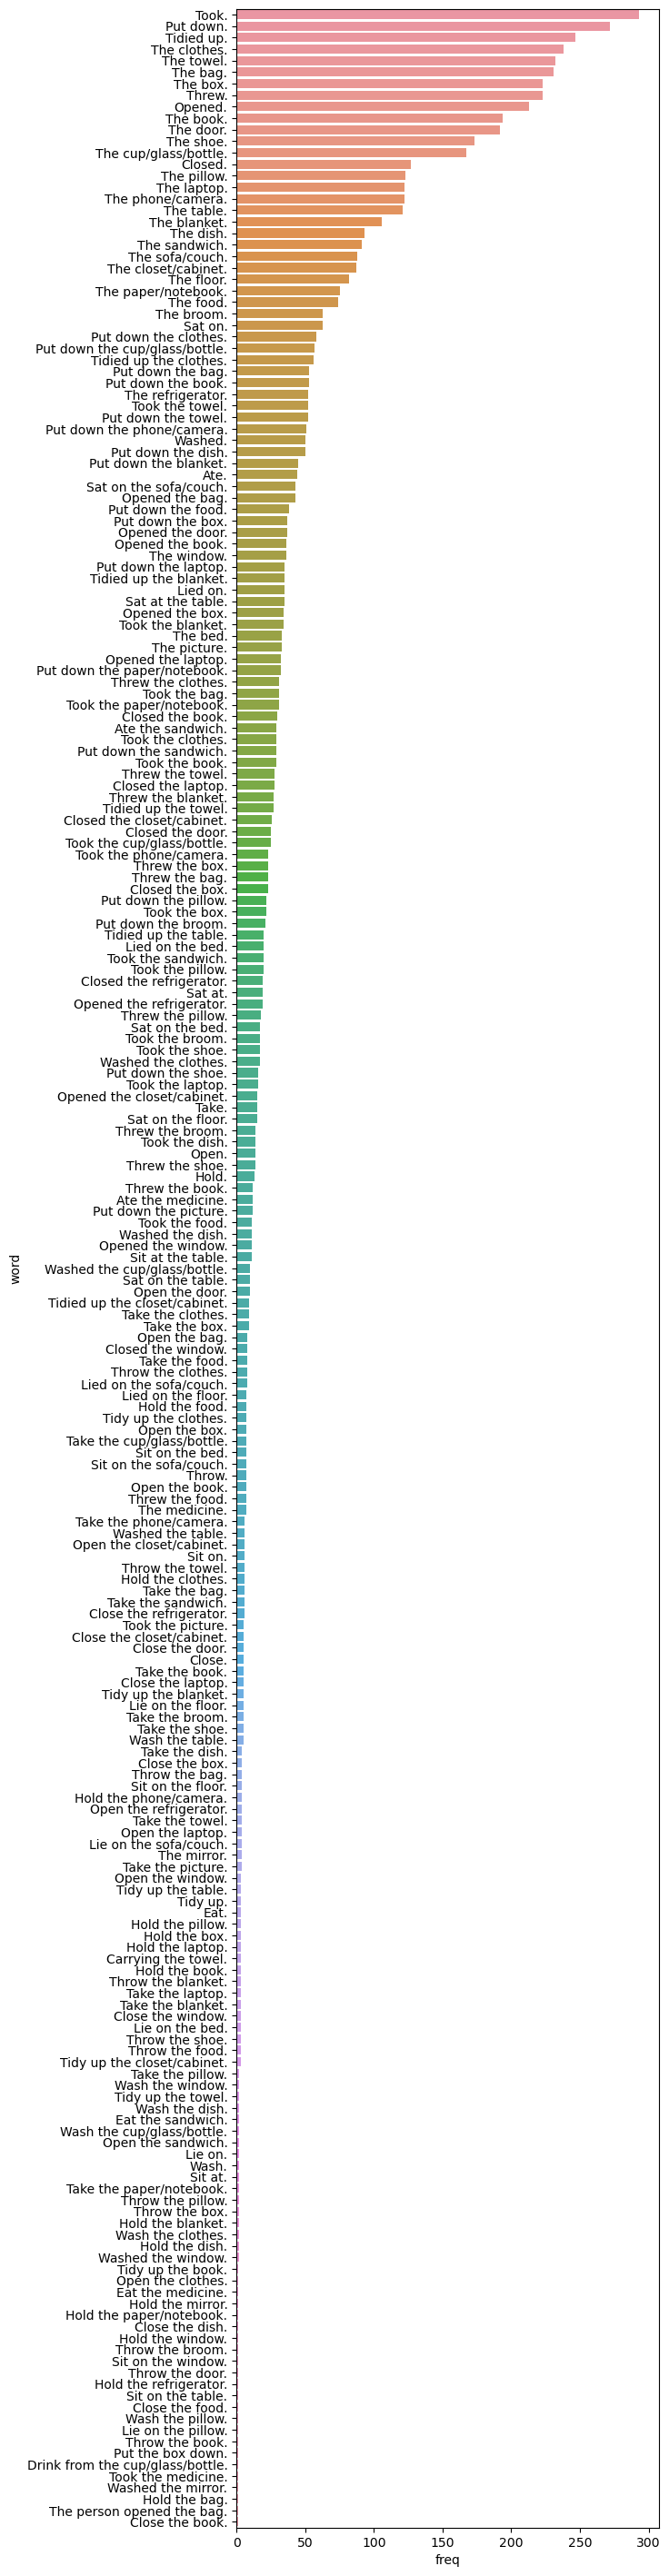

In [80]:
plt.figure(figsize=(6, 36))
sns.barplot(data=freq.sort_values('freq', ascending=False), x='freq', y='word')


Let's do some visualization also for the ground truth data

In [81]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


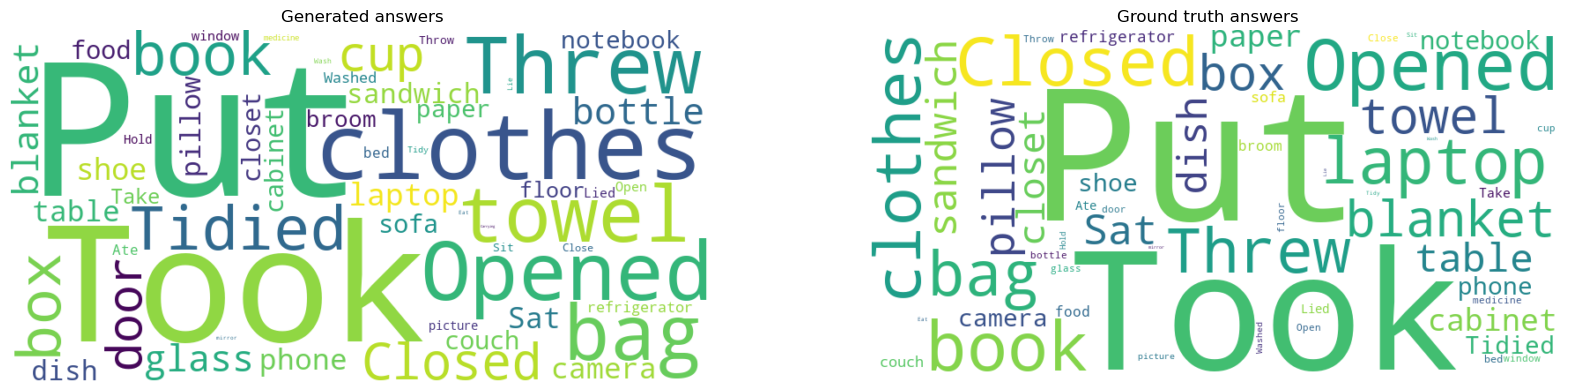

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# predictions worldcloud
pred_text = ' '.join(ans_df['text'].astype(str))
wordcloud1 = WordCloud(width=800,
                       height=400,
                       background_color='white',
                       collocations=False).generate(pred_text)
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Generated answers')

# ground truth wordcloud 
gt_text = ' '.join(gt_df['text'].astype(str))
wordcloud2 = WordCloud(width=800,
                       height=400,
                       background_color='white', 
                       collocations=False).generate(gt_text)
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Ground truth answers')

plt.show()


<AxesSubplot: xlabel='freq', ylabel='word'>

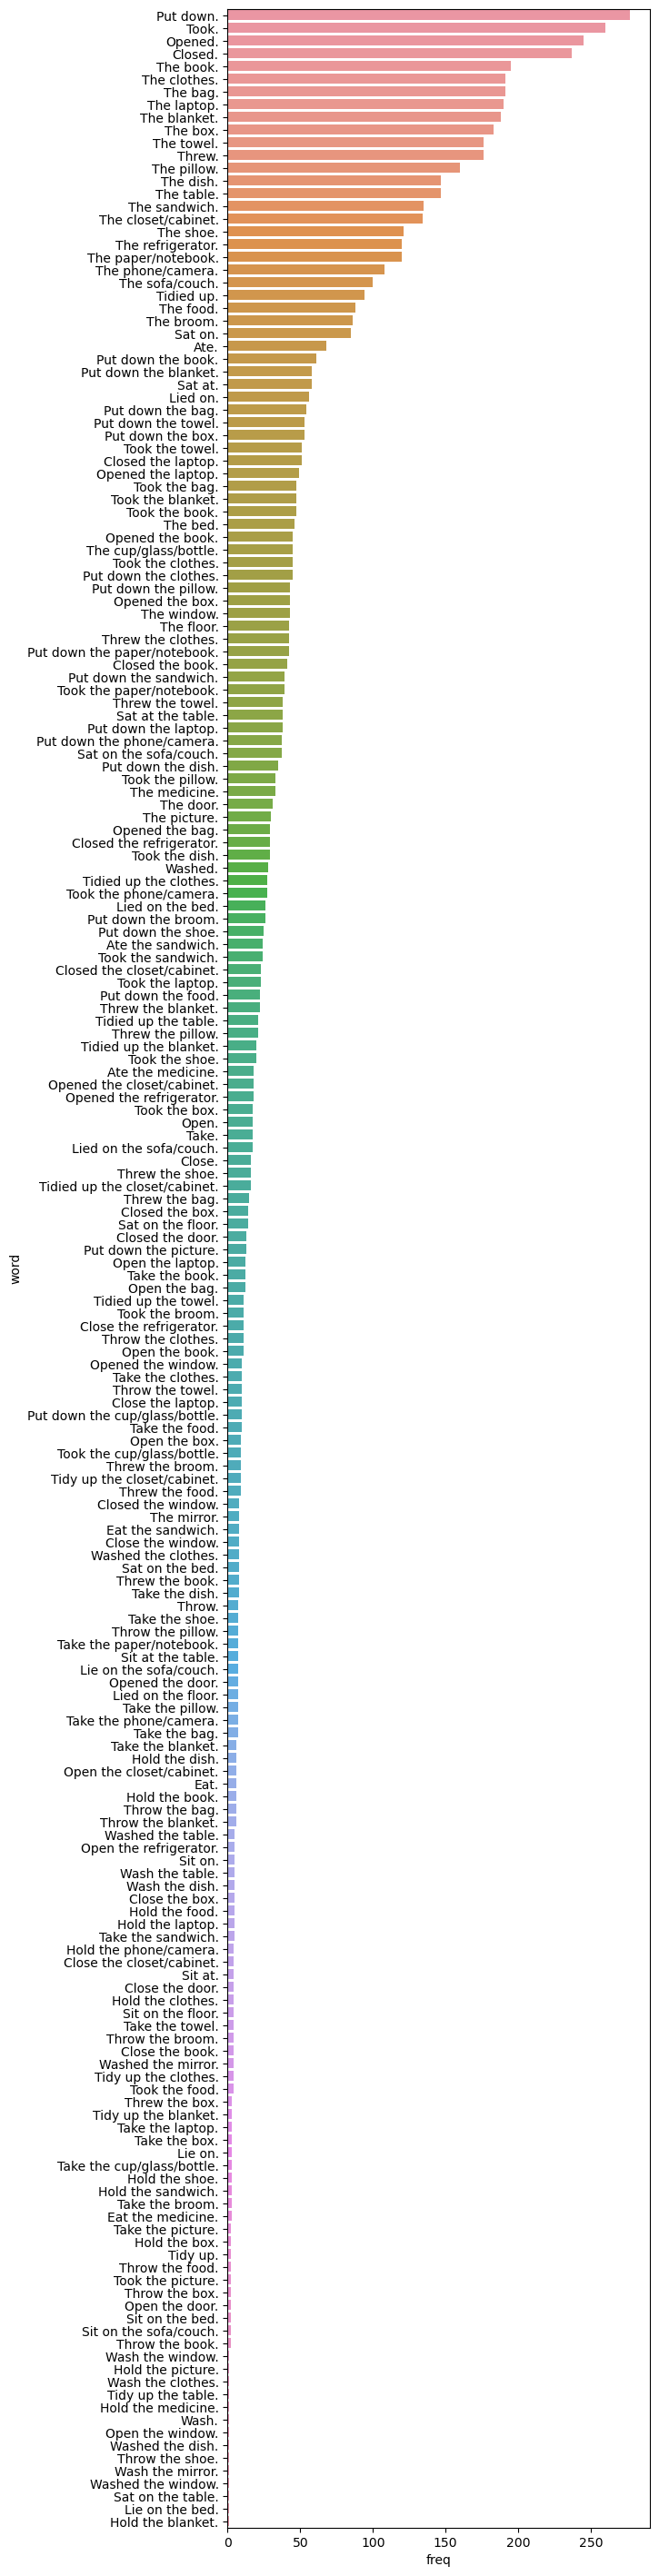

In [83]:
freq = gt_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 36))
sns.barplot(data=freq.sort_values('freq', ascending=False), x='freq', y='word')


In [95]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'num': 'pred_num', 'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='left' # we account also for samples without answers
)

eval_df.shape


(7098, 5)

In [100]:
# how the 'pred_text' looks for samples without answers
eval_df[~contains_answer]['pred_text']


id
Sequence_T3_6372      <NA>
Prediction_T1_757     <NA>
Prediction_T1_911     <NA>
Prediction_T1_1053    <NA>
Prediction_T1_1229    <NA>
Prediction_T1_1331    <NA>
Prediction_T1_1825    <NA>
Prediction_T1_1992    <NA>
Prediction_T1_2066    <NA>
Prediction_T1_2135    <NA>
Prediction_T1_2255    <NA>
Prediction_T1_2592    <NA>
Prediction_T2_105     <NA>
Prediction_T2_1034    <NA>
Prediction_T3_727     <NA>
Prediction_T3_1071    <NA>
Name: pred_text, dtype: string

In [101]:
def accuracy(eval_df, on_what='text'):
    # hits_num = (eval_df['pred_num'] == eval_df['num']).sum()
    hits_text = (eval_df[f'pred_{on_what}'] == eval_df[on_what]).sum()
    

    return hits_text/eval_df.shape[0]


In [102]:
text_acc = accuracy(eval_df)
num_acc = accuracy(eval_df, on_what='num')

print(f"Numeric Accuracy: {num_acc:.2%}")
print(f"Text Accuracy: {text_acc:.2%}")


Numeric Accuracy: 26.36%
Text Accuracy: 30.84%


check if the equality with NA result in a false or is skipped

In [103]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 30.84%


In [109]:

def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [110]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         2398        33.07%  
Sequence            3586        30.42%  
Prediction           624        26.76%  
Feasibility          490        28.16%  


In [111]:
print_acc(eval_df, lambda x: accuracy(x, on_what='num'))


Question type       Total      Accuracy 

Interaction         2398        27.06%  
Sequence            3586        25.49%  
Prediction           624        28.04%  
Feasibility          490        27.14%  


The discrepancy in accuracy values between evaluations conducted on the text portion of the answer and those performed on the numeric prefix suggests that the model struggles to exactly reproduce one of the proposed alternatives.  

Let's check with the prompt for this mismatch

In [ ]:
import re

test_str = "Q: Which object was tidied up by the person?\n0. The closet/cabinet.\n1. The blanket.\n2. The clothes.\n3. The table.\nSTSG."
re.search(r'.*(\d[^\d]+\\n).*STSG', test_str, re.DOTALL)


In [174]:
prompts_df = prompts_df['prompt'].str.split('\n', expand=True)
prompts_df


KeyError: 'prompt'

In [187]:
gt_df


,choices,num,text
id,,,
Interaction_T1_13,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...
Feasibility_T6_1453,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


In [ ]:
prompts_df['gt'] = gt_df['num'] + '. ' + gt_df['text']
prompts_df


,0,1,2,3,4,5,6,gt
id,,,,,,,,
Interaction_T1_13,Q: Which object was tidied up by the person?,0. The closet/cabinet.,1. The blanket.,2. The clothes.,3. The table.,"STSG: [['person - on_the_side_of - clothes'], ...",A:,2. The clothes.
Interaction_T1_14,Q: Which object was tidied up by the person?,0. The blanket.,1. The table.,2. The clothes.,3. The closet/cabinet.,"STSG: [['person - holding - towel', 'person - ...",A:,2. The clothes.
Interaction_T1_31,Q: Which object was thrown by the person?,0. The pillow.,1. The bag.,2. The clothes.,3. The box.,"STSG: [['person - wearing - clothes', 'person ...",A:,2. The clothes.
Interaction_T1_32,Q: Which object was put down by the person?,0. The food.,1. The shoe.,2. The blanket.,3. The sandwich.,"STSG: [['person - on_the_side_of - clothes', '...",A:,1. The shoe.
Interaction_T1_40,Q: Which object was tidied up by the person?,0. The broom.,1. The closet/cabinet.,2. The blanket.,3. The table.,"STSG: [['person - holding - clothes', 'person ...",A:,1. The closet/cabinet.
...,...,...,...,...,...,...,...,...
Feasibility_T6_1453,Q: What is the person able to do after taking ...,0. Wash the table.,1. Take the box.,2. Put down the phone/camera.,3. Open the bag.,"STSG: [['person - on_the_side_of - table', 'pe...",A:,0. Wash the table.
Feasibility_T6_1454,Q: What is the person able to do after walking...,0. Take the towel.,1. Throw the bag.,2. Hold the clothes.,3. Hold the box.,"STSG: [['person - in_front_of - table'], ['per...",A:,0. Take the towel.
Feasibility_T6_1455,Q: What is the person able to do after walking...,0. Throw the bag.,1. Wash the table.,2. Close the box.,3. Take the shoe.,"STSG: [['person - in_front_of - table'], ['per...",A:,1. Wash the table.


In [172]:
ans_df['ans'] = ans_df['pred_num'] + '. ' +  ans_df['pred_text']
ans_df


,pred_num,pred_text,ans
id,,,
Interaction_T1_13,1,The table.,1. The table.
Interaction_T1_14,2,The clothes.,2. The clothes.
Interaction_T1_31,1,The bag.,1. The bag.
Interaction_T1_32,1,The shoe.,1. The shoe.
Interaction_T1_40,2,The clothes.,2. The clothes.
...,...,...,...
Feasibility_T6_1453,1,Take the box.,1. Take the box.
Feasibility_T6_1454,1,Throw the bag.,1. Throw the bag.
Feasibility_T6_1455,0,Throw the bag.,0. Throw the bag.


In [182]:
ans_df.iloc[0]['ans'], prompts_df.iloc[0][4]


('1. The table.', '3. The table.')

In [186]:
(ans_df['ans'] == prompts_df.loc[contains_answer][1]).sum()


2248